# Detector de estrellas candidatas a HVS
En este notebook, se quiere explorar el uso de las fuentes de datos necesarias para el trabajo fin de master *Detecting Intermediate Mass Black Holes in globular clusters using Gaia Home*. Dichas fuentes de datos son:
- Gaia DR3
- XMMNewton (3XMM-DR8 catalogue)
- Chandra (Chandra Source Catalogue-CSC-R2)

Otro objetivo de este notebook es obtener un punto de partida recreando los resultados expuestos en [Tracing black holes in globular clusters with Gaia](https://santiago-ucm.atlassian.net/wiki/spaces/IMBH/overview?homepageId=98423) usando los resultados de DR3 en vex de DR2.


Usaremos astropy  y astroquery para la explotación de las bases de datos. De manera adicional, para la obtención de las coordenadas de los cúmulos globulares usaremos el catálogo *Globular Cluster Systems of Galaxies Catalog* (GCSCAT) integrado en Heasarc. 

### Requirements

In [1]:
%load_ext autoreload
%autoreload 2


#@markdown ### Librerías y funciones auxiliares
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Añadir el directorio raíz del proyecto al sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), "../src"))  # Subir un nivel
if project_path not in sys.path:
    sys.path.append(project_path)
            

from hyper_velocity_stars_detection.astrobjects import AstroObjectProject
from hyper_velocity_stars_detection.jobs.utils import load_project, read_catalog_file
from hyper_velocity_stars_detection.tools.cluster_representations import load_isochrone_from_parsec, cmd_plot, get_best_isochrone_fitted, cmd_with_cluster, cluster_representation_with_hvs
from hyper_velocity_stars_detection.tools.cluster_detection import optimize_clustering, get_main_cluster

/home/santhiperbolico/Documentos/UCM/tfm-ucm-code/src/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
PATH = "../data/"
SELECTED_CLUSTERS = read_catalog_file(os.path.join(PATH, "mwgc.dat.txt"))

In [4]:
CLUSTER_NAME = "ngc 5139"

cluster = [cl for cl in SELECTED_CLUSTERS if cl.name == CLUSTER_NAME][0]
project = load_project(cluster_name=cluster.name, path=PATH)

df_iso = None
distance_module = None
redding = None
print(str(project))

Las muestras analizadas de ngc 5139 son:
Muestras seleccionadas del objeto astronómico ngc 5139 con radio 1:
	 - df_1_c0 - Todas las estrellas seleccionadas: 99125.
	 - df_1_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 21610.
	 - df_1_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 22572.
	 - df_1_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 23220.

Muestras seleccionadas del objeto astronómico ngc 5139 con radio 6:
	 - df_6_c0 - Todas las estrellas seleccionadas: 655.
	 - df_6_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 145.
	 - df_6_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 160.
	 - df_6_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 153.

Se han encontrado 6 fuentes de rayos X.
Estimated number of clusters: 7
Estimated number of noise points: 15235
	 - Volumen total del cluster 0: 6496.
	 - Volumen 

In [51]:
dfr1 = project.data_list[0].get_data("df_1_c2")
df_iso = load_isochrone_from_parsec("output258596335844.dat.txt")
distance_module, redding = get_best_isochrone_fitted(dfr1, df_iso)
distance_module, redding

/home/santhiperbolico/Documentos/UCM/tfm-ucm-code/src/hyper_velocity_stars_detection/tools/cluster_representations.py:92: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_isochrone = pd.read_csv(


(np.float64(12.994592875533943), np.float64(-0.16108173824371577))

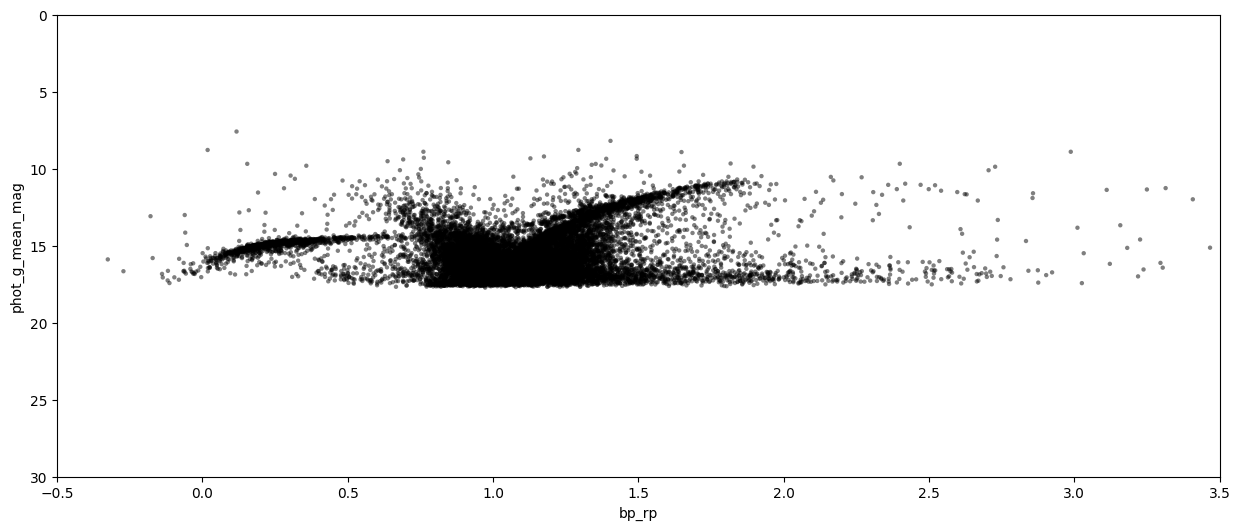

In [132]:
dfr1 = project.data_list[0].get_data("df_1_c2")

ax, fig = cmd_plot(dfr1, df_iso, isochrone_distance_module=distance_module, isochrone_redding=redding
                  )
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(30, 0)
plt.show()

In [133]:
columns_to_clus=["pmra", "pmdec", "parallax", 
                 'bp_rp', 
                 'phot_g_mean_mag'
                ]
clustering = project.cluster_detection(
    data_name="df_1_c2",
    columns=["pmra", "pmdec", "parallax"], 
    columns_to_clus=columns_to_clus,
    max_cluster=10,
    method="dbscan",
    n_trials=100
)

print(str(project.clustering_results))

project.save_project(PATH)

[I 2025-03-07 19:29:43,407] A new study created in memory with name: no-name-c0d1aaea-844c-4309-b008-ef356ef4eca2
[I 2025-03-07 19:29:45,510] Trial 0 finished with value: 1000000.0 and parameters: {'eps': 0.8013546469454753, 'min_samples': 10}. Best is trial 0 with value: 1000000.0.
[I 2025-03-07 19:29:45,749] Trial 1 finished with value: 0.674616287287601 and parameters: {'eps': 0.10438369296661983, 'min_samples': 10}. Best is trial 1 with value: 0.674616287287601.
[I 2025-03-07 19:29:47,561] Trial 2 finished with value: 3.8435224295455934 and parameters: {'eps': 0.7300349825319352, 'min_samples': 8}. Best is trial 1 with value: 0.674616287287601.
[I 2025-03-07 19:29:49,811] Trial 3 finished with value: 27.807243464481196 and parameters: {'eps': 0.8474919337243253, 'min_samples': 3}. Best is trial 1 with value: 0.674616287287601.
[I 2025-03-07 19:29:52,024] Trial 4 finished with value: 1000000.0 and parameters: {'eps': 0.827496019288915, 'min_samples': 8}. Best is trial 1 with value: 

Estimated number of clusters: 7
Estimated number of noise points: 15235
	 - Volumen total del cluster 0: 6496.
	 - Volumen total del cluster 1: 712.
	 - Volumen total del cluster 2: 8.
	 - Volumen total del cluster 3: 9.
	 - Volumen total del cluster 4: 8.
	 - Volumen total del cluster 5: 8.
	 - Volumen total del cluster 6: 7.



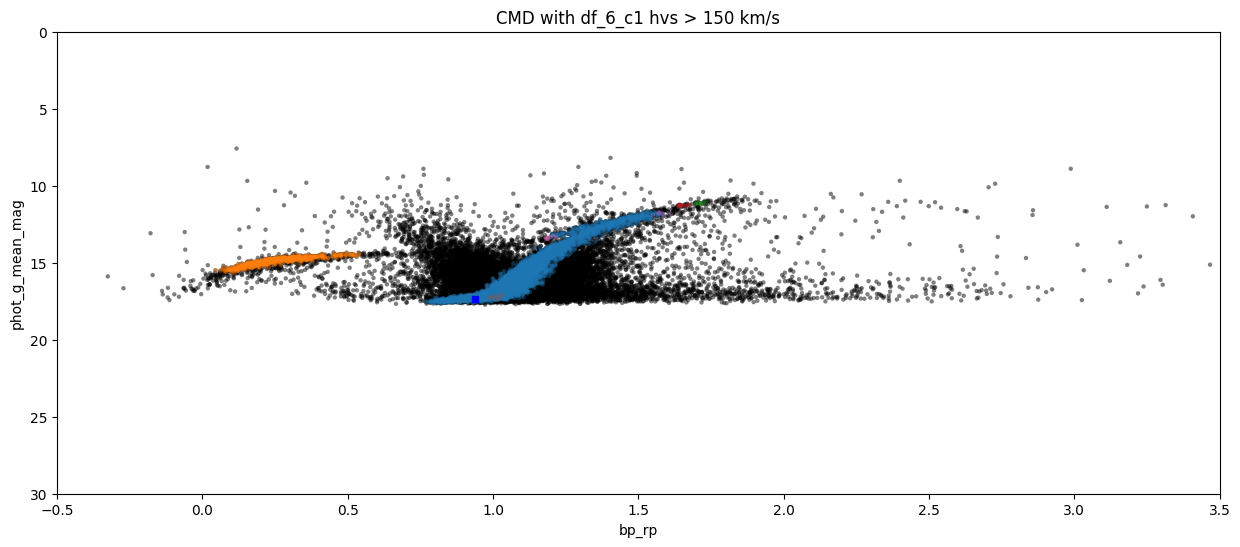

In [171]:
mask_nan = dfr1[columns_to_clus].isna().any(axis=1).values
data = dfr1[~mask_nan]

fig, ax = project.plot_cmd(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 2.0,
            hvs_pm = 150,
            df_isochrone = df_iso,
            isochrone_distance_module=distance_module, 
            isochrone_redding=redding,
            legend=False
)
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(30, 0)
plt.show()

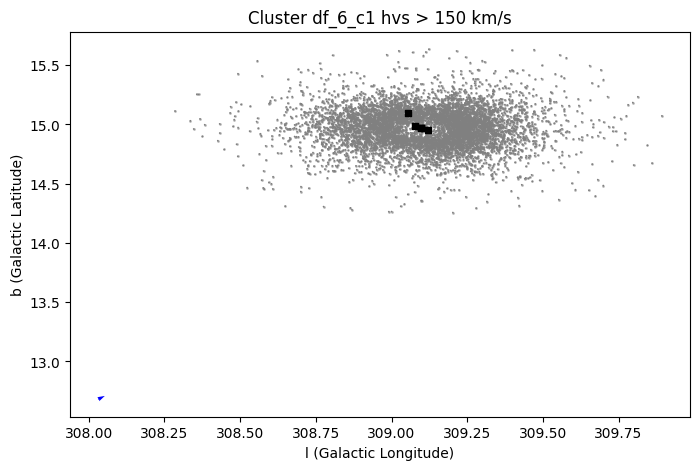

In [170]:
fig, ax = project.plot_cluster(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 2.0,
            hvs_pm = 150,
            legend=False
)
plt.show()

In [5]:
mask = project.clustering_results.labels == get_main_cluster(project.clustering_results.labels)
gc = project.clustering_results.gc

print("Número de estrellas de CLuster seleccionado: %d" % gc.shape[0])
print("Número de HVS del CLuster seleccionado: %d" % gc[gc.pm_kms>200].shape[0])
display(gc[["pmra", "pmdec", "parallax"]].describe())

Número de estrellas de CLuster seleccionado: 6496
Número de HVS del CLuster seleccionado: 4071


,pmra,pmdec,parallax
count,6496.000000,6496.000000,6496.000000
mean,-3.247813,-6.746317,0.158353
std,0.414702,0.394999,0.073703
min,-4.767986,-8.081055,-0.103168
25%,-3.532978,-7.016215,0.114754
50%,-3.247434,-6.744771,0.157651
75%,-2.964428,-6.476889,0.199291
max,-1.667298,-5.469871,0.481286


In [9]:
project.xsource

,bii,dec,duration,end_utc,footprint_fov,heasarc_code,lii,moving_target,observation_id,observation_oid,...,proprietary_end_date,ra,ra_nom,revolution,sas_version,seq_id,start_utc,stc_s,target,with_science
0,14.972433,-47.475833,40567,2001-08-13T10:50:51.0,"[201.72091066626, -47.7343371679216, 201.58548...",3080,309.098943,False,0112220101,55616,...,2002-09-22T00:00:00.0,201.691666,13.446111,307,xmmsas_20190401_1820-18.0.0,133564,2001-08-12T23:34:44.0,Polygon J2000 201.7539511824654 -47.7343264962...,Omega Cen,True
1,14.990062,-47.461223,9374,2000-02-18T02:27:42.0,NaN,-1,309.078082,False,0117730401,56012,...,2000-03-08T00:00:00.0,201.658455,13.443897,35,xmmsas_20190401_1820-18.0.0,144655,2000-02-17T23:51:28.0,,,False
2,14.971334,-47.476940,30748,2000-02-16T22:42:53.0,"[201.710766710674, -47.714753730061794, 201.66...",3080,309.098781,False,0117740101,56014,...,2002-09-22T00:00:00.0,201.691650,13.446110,35,xmmsas_20190401_1820-18.0.0,142224,2000-02-16T14:10:25.0,Polygon J2000 201.71076671067445 -47.714753730...,Omega Cent,True
3,14.971334,-47.476940,5408,2005-01-07T20:16:03.0,NaN,3080,309.098781,False,0212090401,58084,...,2005-01-07T00:00:00.0,201.691650,13.446110,931,xmmsas_20190401_1820-18.0.0,143979,2005-01-07T18:45:55.0,,Omega Centauri,True
4,14.949733,-47.495250,5271,2005-08-17T22:42:07.0,NaN,3080,309.121229,False,0310990101,58858,...,2005-08-17T00:00:00.0,201.727950,13.448530,1042,xmmsas_20190401_1820-18.0.0,143990,2005-08-17T21:14:16.0,,Omega Centauri,True
5,15.100343,-47.355250,24113,2006-08-21T15:43:15.0,"[201.598834121117, -47.5950615407564, 201.5922...",1500,309.054401,False,0412780101,59710,...,2006-08-21T00:00:00.0,201.602100,13.440140,1227,xmmsas_20190401_1820-18.0.0,142796,2006-08-21T09:01:22.0,Polygon J2000 201.64496766006545 -47.595051957...,Omega Centauri,True


## Referencias
- Kızıltan, B., Baumgardt, H., & Loeb, A. (2017). An intermediate-mass black hole in the centre of the globular cluster 47 Tucanae. Nature, 542(7640), 203-205.